# Welcome to my project!

I am planning to transition a lot of the boilerplate / "utility" cells into a Python package, or import from a Github repo.

In [1]:
# !git clone https://github.com/aaronzr/Liquid-Jet-Laser-Lensing.git
# !ls

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from abc import ABC, abstractmethod
import typing
from collections.abc import Iterable

from src.utils import *
from src.optics import *


In [3]:
# verify imports
n2a(1)
print(FreeSpace(1))

FreeSpace(d=1), hellohello


# Gaussian beam optics


## Introduction


In the paraxial approximation ($\sin \theta \approx \tan \theta \approx \theta$), ray optics becomes linear. Optical components then perform linear operations on rays, which are characterized by their position and angle:

$$
\begin{pmatrix} x' \\ \theta' \end{pmatrix}
=
\begin{pmatrix} A & B \\ C & D \end{pmatrix}
\begin{pmatrix} x \\ \theta \end{pmatrix}
$$

We simulate propagation of a Gaussian beam through an arbitrary optical system consisting of thin lenses, thick lenses, and free space propagation regions. The Gaussian beam is described a beam waist $w(z)$ and radius of curvature $R(z)$.

(The beam waist is defined as the radial distance at which the intensity falls to $1/e^2$ of its maximum value; therefore, $w=2\sigma$, where $\sigma$ is the standard deviation of the Gaussian distribution.)

These are combined into the q-value $q(z)$ according to

$$
\begin{align}
\frac 1 {q(z)} &= \frac 1 {R(z)} + i \frac{\lambda}{\pi n(z) w(z)^2}
\end{align}
$$

We can recover $w(z)$ from $q(z)$ via

$$
w(z) = \left[\frac{\lambda}{\pi n(z) \cdot \text{Im}\left(\frac{1}{q(z)}\right)}\right]^{1/2}
$$


(Note that we write $n(z)$ since $n$ can vary along the optical axis, e.g. when passing through media.)

The Rayleigh length is the length over which the beam waist grows by $\sqrt 2$:
$$z_R = \frac{\pi n w_0}{\lambda}$$

To propagate a Gaussian beam through a linear optical system, we apply the ray transfer matrices to a vector $\begin{pmatrix}q \\ 1\end{pmatrix}$, then normalize the result such that the second element of the new vector is still 1:

$$
\begin{pmatrix} q' \\ 1 \end{pmatrix}
=
\frac{\begin{pmatrix} A & B \\ C & D \end{pmatrix}\begin{pmatrix} q \\ 1 \end{pmatrix}}
{\begin{pmatrix} 0 & 1 \end{pmatrix}\begin{pmatrix} A & B \\ C & D \end{pmatrix}\begin{pmatrix} q \\ 1 \end{pmatrix}}
$$

This is equivalent to

$$
q' = \frac{Aq + B}{Cq + D}
$$

By tracking how $q$ evolves, we can plot various quantities, such as beam waist and radius, as they vary along the $z$ axis of an optical system.



## Constants

In [4]:
# Input beam params
L0 = 266e-9 # m  # Wavelength
W0 = 8e-3 # m    # Beam waist
N0 = 1           # Free space index of refraction
R0 = np.infty    # Beam radius of curvature (infinite at focus)

# Rayleigh length of input beam
Z_R = np.pi * W0**2 * N0 / L0  # m
print(f"Rayleigh length: {Z_R} m")

# System params
F_LENS = 0.750 # m  # Focal length of focusing thin lens
Z_LENS = 0          # Location of focusing thin lens
Z_JET = Z_LENS + F_LENS   # Location of jet center
R_JET = 50e-6 # m   # Jet radius: R1 = R2 = R; thickness: t = 2R
N_JET = 1.33        # Jet idx of refraction (water)
T_SHEET = 2*R_JET # m    # Thickness of jet/sheet


Rayleigh length: 755.8719166531832 m


NOTE: get Rayleigh length just after focusing jet

## Comparing systems: jet, sheet, no jet

First, we look at how the beam waist varies as the Gaussian beam propagates through systems with and without a liquid jet. The liquid jet is located at the focal point of the focusing lens, $z_{\text{jet}}=f_{\text{lens}}$.

In [12]:
# System with jet, radius R_jet
def sys_jet(z_lens=Z_LENS, f_lens=F_LENS, z_jet=Z_JET,
            r_jet=R_JET, n_jet=N_JET):
  sys = OpticalSystem()
  sys.add(ThinLens(f_lens), z=z_lens)
  sys.add(ThickLens(R1=r_jet, R2=-r_jet, t=2*r_jet, n=n_jet), z=z_jet)
  return sys

# System with sheet, thickness t = 2*R_jet
def sys_sheet(z_lens=Z_LENS, f_lens=F_LENS, z_sheet=Z_JET,
              t_sheet=T_SHEET, n_sheet=N_JET):
  sys = OpticalSystem()
  sys.add(ThinLens(f_lens), z=z_lens)
  sys.add(Sheet(t=t_sheet, n=n_sheet), z=z_sheet)
  return sys

# System without jet
def sys_no_jet(z_lens=Z_LENS, f_lens=F_LENS):
  sys = OpticalSystem()
  sys.add(ThinLens(f_lens), z=z_lens)
  return sys

# Propagate Gaussian beam q0 through all systems;
# record q(z), n(z), w(z)
breakpoint()
SCALE = 1e6 # scale to microns
SCALE_STR = ' μm'

Z1 = Z_LENS - F_LENS
Z2 = Z_LENS + 5*F_LENS

systems = {'jet': sys_jet(),
           'sheet': sys_sheet(),
           'no jet': sys_no_jet()}
labels = ['$R_{jet}=$' + str(R_JET*SCALE) + SCALE_STR,
          '$t_{sheet}=$' + str(T_SHEET*SCALE) + SCALE_STR,
          'no jet']
colors = ['b','xkcd:sky blue','k--']

q0 = q(R0, L0, N0, W0)

def compare(q0, z1, z2, systems, labels, colors, l0=L0,
            xscale=1, yscale=1, x0=0, y0=0):
  '''
  Compare propagation of a Gaussian beam `q0` through a list of optical systems.
  '''
  z = np.linspace(z1, z2, int(1e3))
  # propagate
  for n in range(len(systems)):
    sys = systems[n]
    q_z = sys.propagate(q0, z)
    w_z = np.real(q2w(q_z, sys.n(z), l0))
    # plot
    plt.semilogy((z-x0)*xscale, (w_z-y0)*yscale, colors[n], label=labels[n])

compare(q0,Z1,Z2,list(systems.values()),labels,colors)

plt.title('Beam waist $w(z)$; $w_0=$' + str(W0*1e3) + ' mm')
plt.xlabel('z [m]')
plt.ylabel('w [m]')
# plt.ylim(0, np.max(w_jet))
plt.legend()
plt.show()

AttributeError: 'function' object has no attribute 'shape'

Same plot, zoomed in to the vicinity of the jet

In [31]:
# Comparison near jet

z1_fine = Z_JET - 2*R_JET # before front of jet
z2_fine = Z_JET + 3*R_JET # after back of jet

# Scale to microns
XSCALE = 1e6
XSCALE_STR = ' μm'
YSCALE = 1e6
YSCALE_STR = ' μm'

# Propagate the beam up to the front of the jet
q_init = systems['no jet'].propagate(q0, [Z_LENS, z1_fine])[-1]
compare(q_init, z1_fine, z2_fine, list(systems.values()), labels, colors,
        xscale = XSCALE, yscale=YSCALE, x0=Z_JET)

plt.title('Beam waist $w(z)$ near jet; $w_0=$' + str(W0*1e3) + ' mm')
plt.xlabel('Displacement from jet center $z - z_{jet}$ [μm]')
plt.ylabel('w [μm]')

# plot boundaries of jet
y_arr = np.array([1e-5, 1e-4])*YSCALE
x_front = np.array([-R_JET] * len(y_arr))*XSCALE
x_back = np.array([R_JET] * len(y_arr))*XSCALE
plt.plot(x_front, y_arr, 'b:',label='jet boundary')
plt.plot(x_back, y_arr, 'b:')

plt.legend()
plt.show()

TypeError: OpticalSystem.get_matrix() takes 2 positional arguments but 3 were given

# Imaging

We add a thin imaging lens ($f_{\text{img}} = 15\text{ cm}$) after the jet to magnify the image onto a camera a distance $d_{\text{Camera}} \sim \text{1 m}$ away to achieve a magnification of $M \sim 5$.




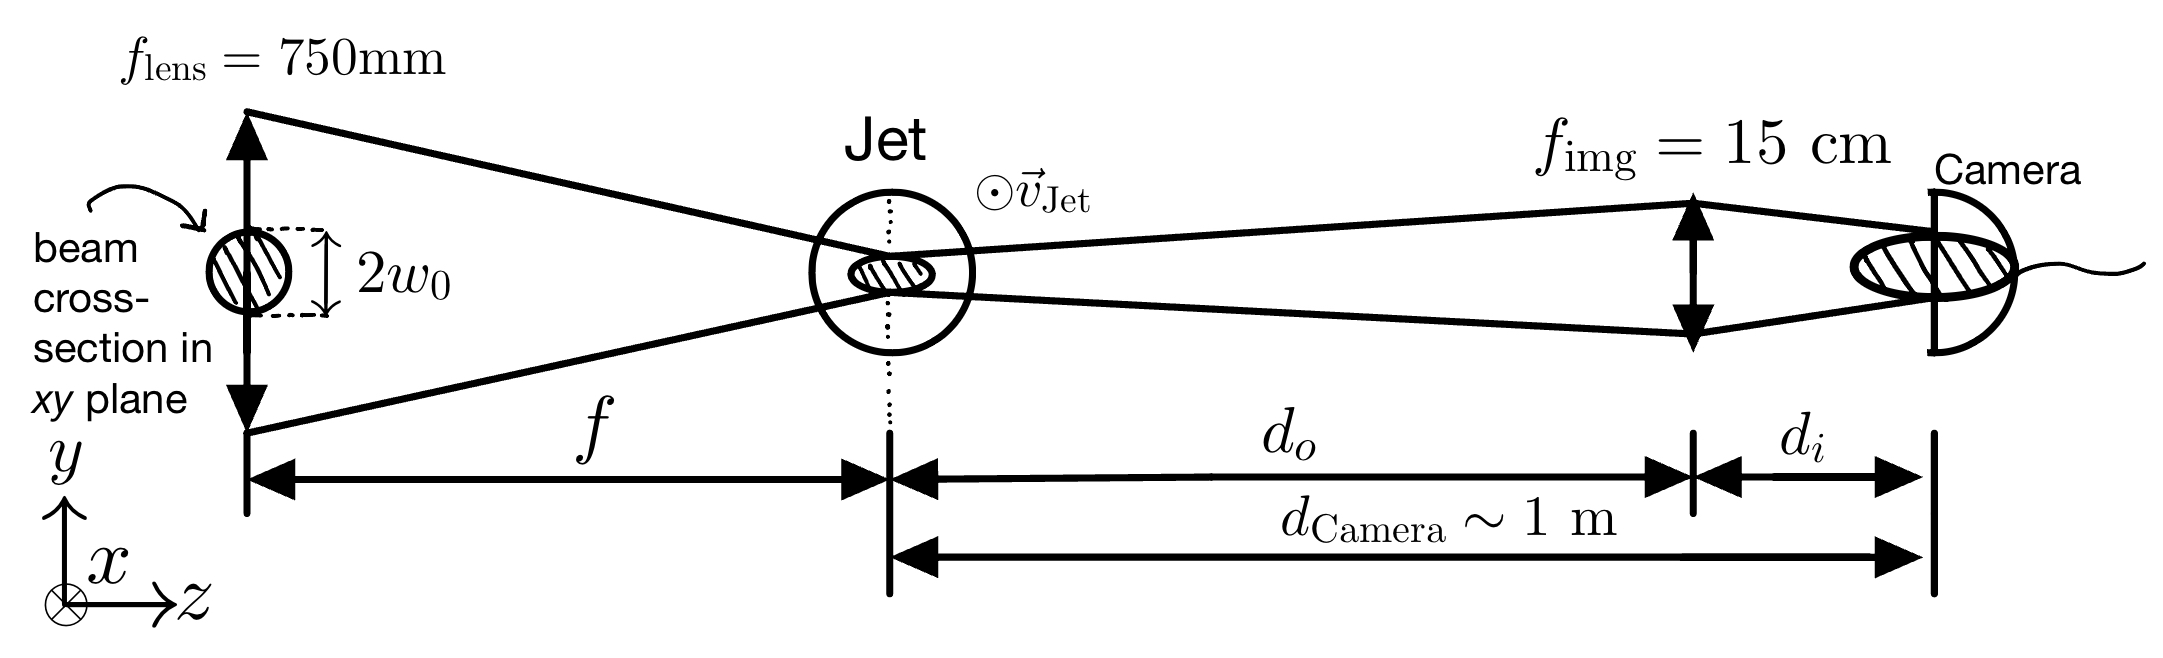

We solve for $d_o$ and $d_i$ using the definition of magnification and the thin lens equation:
$$
\begin{align}
\begin{cases}
M = \frac{d_i}{d_o} & \text{(def. of magnification)}\\
\frac{1}{f_{\text{img}}} = \frac{1}{d_i} + \frac{1}{d_o} &\text{(thin lens eqn.)}
\end{cases}
\\
\implies d_i = (1+M)f_{\text{img}};\quad d_o = \frac{1+M}{M}f_{\text{img}}
\end{align}
$$

In [ ]:
# Constants

M = 5                   # Magnification
F_IMG = 0.15 # m        # 15cm focal length is an available size
D_I = (1+M) * F_IMG     # Lens - camera distance
D_O = D_I/M             # Jet - lens distance
D_CAM = D_O * (1 + M)   # Jet - camera distance

offset = 0
Z_IMG = Z_JET + offset + D_O     # Imaging lens location
Z_CAM = Z_JET + offset + D_CAM   # Camera location

print(f"Focal length of imaging lens: {F_IMG} m")
print(f"Distance from jet to camera: {D_CAM} m")
print(f"Distance from jet to imaging lens: {D_O} m")
print(f"Distance from imaging lens to camera: {D_I}")

Focal length of imaging lens: 0.15 m
Distance from jet to camera: 1.08 m
Distance from jet to imaging lens: 0.18 m
Distance from imaging lens to camera: 0.8999999999999999


## Define imaging systems: jet, sheet, no jet

In [ ]:
# Add imaging lenses to the previous optical systems

def sys_img_jet(r_jet=R_JET, z_lens=Z_LENS, f_lens=F_LENS,
                f_img=F_IMG, z_img=Z_IMG):
  sys = OpticalSystem()
  sys.add(sys_jet(r_jet=r_jet), z=z_lens) # add the previous optical system (including jet)
  sys.add(ThinLens(f_img), z=z_img) # add imaging lens at z = f + z_o
  return sys

def sys_img_sheet(t_sheet=2*R_JET, z_lens=Z_LENS, f_lens=F_LENS,
                  f_img=F_IMG, z_img=Z_IMG):
  sys = OpticalSystem()
  sys.add(sys_sheet(t_sheet=t_sheet), z=z_lens) # add the previous optical system (including jet)
  sys.add(ThinLens(f_img), z=z_img) # add imaging lens at z = f + z_o
  return sys

def sys_img_no_jet(z_lens=Z_LENS, f_lens=F_LENS,
                   f_img=F_IMG, z_img=Z_IMG):
  sys = OpticalSystem()
  sys.add(sys_no_jet(), z=z_lens)
  sys.add(ThinLens(f_img), z=z_img)
  return sys


## Compare imaging systems

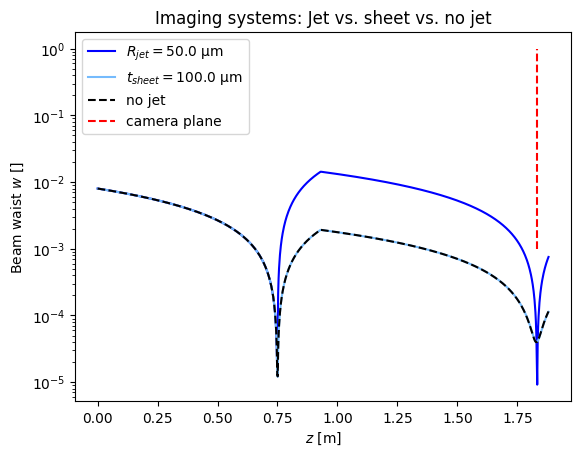

In [ ]:
# Compare propagation through 3 systems (no jet, jet, jet + imaging lens)

z1 = Z_LENS
z2 = Z_CAM + 0.05 # go 5cm past detector surface
q0 = q(R0, L0, N0, W0)

systems = [sys_img_jet(),
           sys_img_sheet(),
           sys_img_no_jet()]

labels = ['$R_{jet}=$' + str(R_JET*1e6) + ' μm',
          '$t_{sheet}=$' + str(T_SHEET*1e6) + ' μm',
          'no jet']
colors = ['b','xkcd:sky blue','k--']

# compare
compare(q0, z1, z2, systems, labels, colors)

plt.title('Imaging systems: Jet vs. sheet vs. no jet')
plt.xlabel('$z$ [m]')
plt.ylabel('Beam waist $w$ []')

# plot camera position
y_arr = np.array([1e-3,1])
x_cam = [Z_CAM] * len(y_arr)
plt.plot(x_cam, y_arr, 'r--', label='camera plane')
plt.legend()
plt.show()

# Parameter sweeps

We want to compute the minimum beam width achieved within the optical system, $\min_z \text{FWHM}(z)$, as a function of initial beam width, $\text{FWHM}_0$.

FWHM is related to beam waist via

$$
w(z) = \frac{\text{FWHM}(z)}{\sqrt{2\ln 2}} \approx 0.84\cdot \text{FWHM}(z)
$$
https://en.wikipedia.org/wiki/Gaussian_beam#Evolving_beam_width

and to standard deviation $\sigma$ via

$$\mathrm{FWHM} =   2\sqrt{2 \ln 2 } \; \sigma \iff w = 2\sigma$$

We plot this dependency for several jet diameters
$$R_\text{jet} \in \{10,25,50\} \text{μm}$$

For each $R_{\text{jet}}$, we let the initial FWHM (at z = 0) vary between $$1 \text{mm} < \text{FWHM}(z=0) < 10 \text{mm}$$
<!--
To increase the accuracy of the simulation while saving computation, we adopt the following approach:

* For each $\text{FWHM}_i \in [50\text{μm}, 200\text{μm}]$, discretize $z$ into $N$ intervals, so $\Delta z = (f+d_{\text{Det}})/N := z_{\text{Det}}/N$.
* Find $z_{\text{min}}^{(1)}$, a first-order approximation to where the minimum $\text{FWHM}$ occurs
* Divide the interval $[z_{\text{min}}^{(1)} - \Delta z, z_{\text{min}}^{(1)} + \Delta z]$ into $N$ intervals and find the minimum again. Call it $z_{\text{min}}^{(2)}$.

This allows us to achieve a precision of $z_{\text{Det}}/N^2$ precision with only $2N$ operations.

We use this numerical approach to get a sense of where in the optical system the minimum occurs. Once we know this, we will be able to compute the minimum analytically. -->

## Parameter ranges & utility function

In [ ]:
N_w0 = 1000 # number of beam waist points
fwhm_0_arr = np.linspace(1e-3, 25e-3, N_w0)  # m # Input beam FWHM
w0_arr = f2w(fwhm_0_arr)                        # Input beam waist
r_jet_arr = np.array([10e-6, 25e-6, 30e-6, 40e-6, 50e-6, 60e-6, 100e-6]) # m # Jet radii

In [ ]:
def get_min_w(q1, sys, z1, z2, n_points=1000):
  '''
  Find the minimum value that w takes between z1 and z2
  q1 = q(z1)
  '''
  # Propagate through bulk of jet
  z = np.linspace(z1, z2, n_points) # shape: (n_points)
  q_z = sys.propagate(q1, z)        # shape: (N_w0 = len(q1), n_points)
  w_z = np.real(q2w(q_z, sys.n(z), L0)) # shape: (N_w0, n_points)
  # breakpoint()
  # Find position and value of minimum w
  w_min = np.min(w_z, axis=1) # shape: (N_w0)
  z_min = z[np.argmin(w_z, axis=1)] # shape: (N_w0)
  return w_min, z_min

## Comparison of 2D spot sizes

Let $z_{\min}$ be the location *within the jet* where $w_y$ is minimal. We showed above that the drop in $w_y$ across the jet is independent of jet diameter, but the jet diameter determines where $w_x$ is measured. The intensity is inversely proportional to the area $A$ of an ellipse with axes $w_x(z_{\min})$ and $w_y(z_{\min})$, so the maximum intensity occurs when $A$ is minimized:

$$
\begin{align}
I_\max &∝ \frac{1}{A_\min}; \\ A_{\min} &= \pi w_x(z_{\min})w_y(z_{\min})
\end{align}
$$

We graph inverse minimum spot size ($1/A_\min ∝ I_\max$) against input jet diameter $D = \text{FWHM}(z=0)$.

For each system:
1.  Propagate $q_0$ up to the front of the jet
2.  Find $\min_z(w_y)$ and $z_{\text{min}} = \arg\min_z(w_y)$ within the jet
3.  Calculate $w_x$ at $z_{\min}$
4.  Find $A_\min = \pi w_x w_y$

Repeat for each $(w_0, r_{\text{jet}})$ in `w0_arr`, `r_jet_arr`

## Non-focusing dimension

The liquid jet extends in the $x$ direction. It looks like a spherical lens of radius $R_{\text{jet}}$ in the $yz$ plane, but a sheet of thickness $t_\text{sheet}=2R_{\text{jet}}$ in the $xz$ plane.

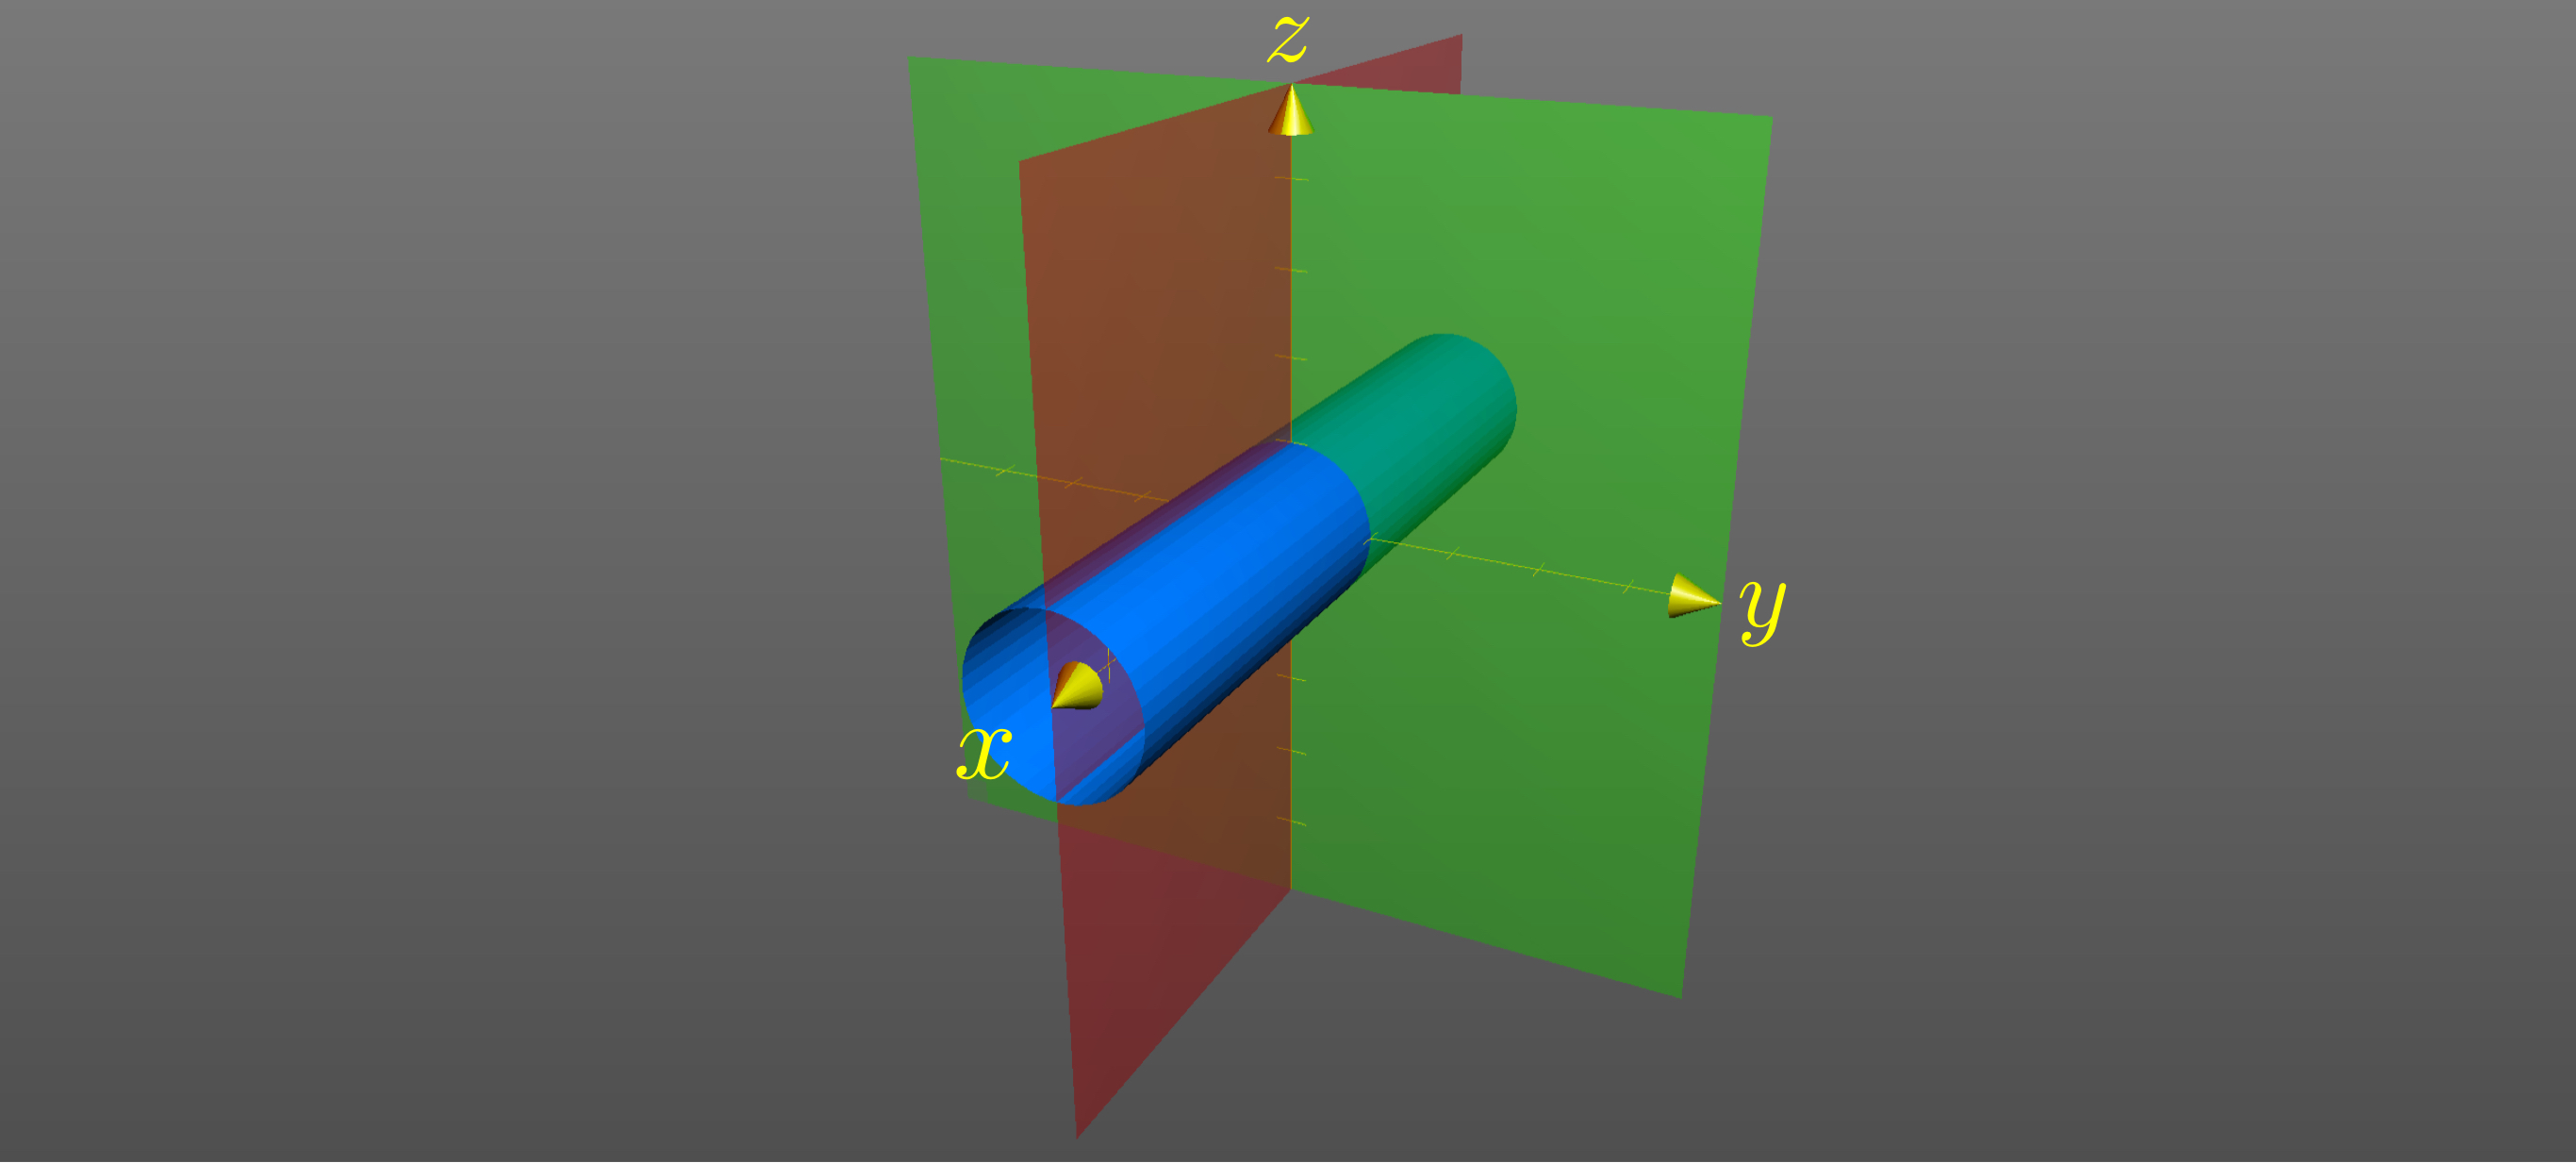

In [ ]:
q0 = q(R0, L0, N0, w0_arr)  # shape: (N_w0)

# Define xz and yz systems for each r_jet
sys_jet_y_r = [sys_img_jet(r_jet=r) for r in r_jet_arr]
sys_jet_x_r = [sys_img_sheet(t_sheet=2*r) for r in r_jet_arr]

# Take (z1,z2) to be the boundaries of the jet
z1_r = np.array([Z_JET - r for r in r_jet_arr]) # shape: (3)
z2_r = np.array([Z_JET + r for r in r_jet_arr]) # shape: (3)

# 1. Propagate up to z1 for each R_jet
q_init_r = np.array([sys_img_no_jet().propagate(q0, [Z_LENS, z1])[:,-1] \
                     for z1 in z1_r]) # shape: (3, N_w0)

A_r = []
w_y_r = []
w_x_r = []
z_min_r = []

for i in range(len(r_jet_arr)):
  # 2. Find w_y_min = $\min_z(w_y)$ and z_min. Shape: (N_w0)
  w_y_min, z_min = get_min_w(q_init_r[i], sys_jet_y_r[i], z1_r[i], z2_r[i])
  w_y_r.append(w_y_min)
  z_min_r.append(z_min)
  # 3. Calculate w_x at z_min. Shape: (N_w0)
  q_x = np.array([sys_jet_x_r[i].propagate(q0[idx], [Z_LENS, z_min[idx]])[-1] for idx in range(len(z_min))]) # shape: (N_w0)
  w_x = np.real(q2w(q_x, N_JET, L0))
  w_x_r.append(w_x)
  # 4. Calculate area of ellipse at z_min. Shape: (N_w0)
  A = np.pi * w_x * w_y_min
  A_r.append(A)


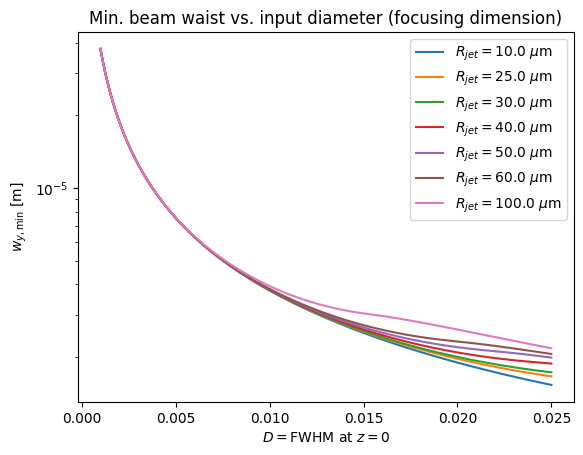

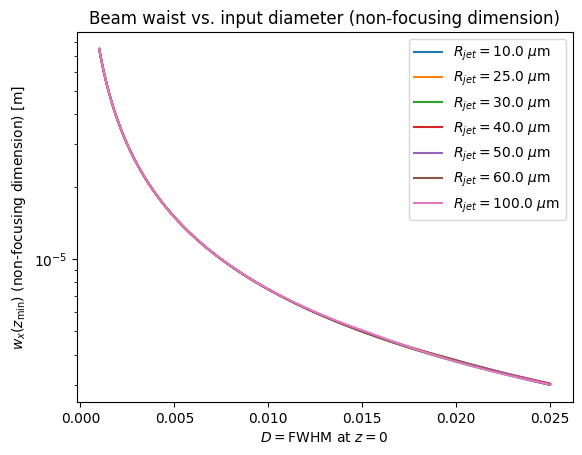

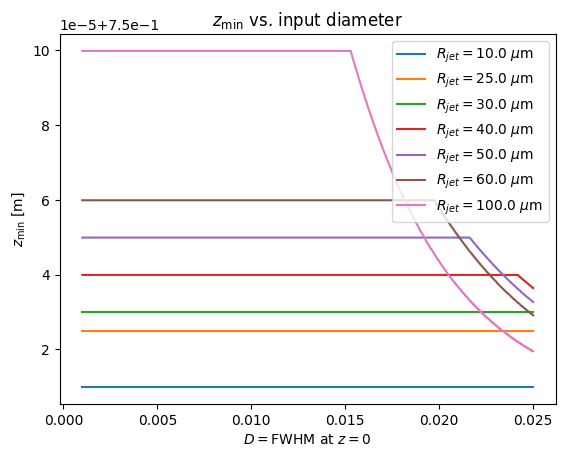

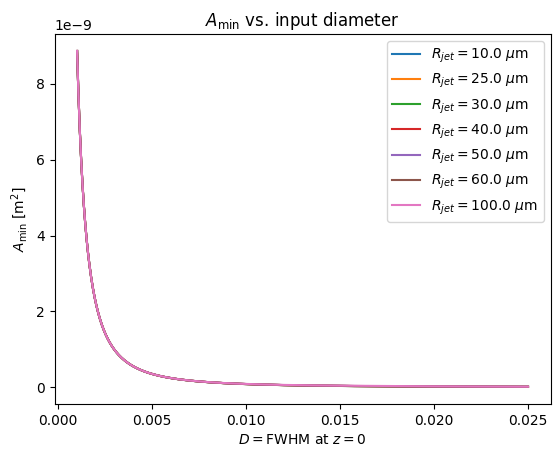

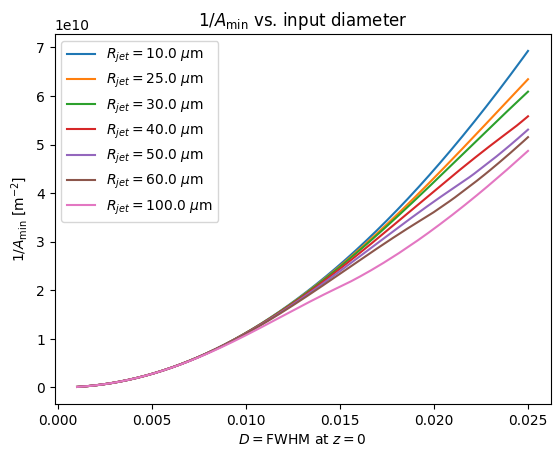

In [ ]:
# PLOT

# D: initial beam diameter (FWHM)

D = w2f(w0_arr)

plt.figure()
plt.title('Min. beam waist vs. input diameter (focusing dimension)')
plt.xlabel('$D=$FWHM at $z=0$')
plt.ylabel('$w_{y,\min}$ [m]')
for i in range(len(r_jet_arr)):
  plt.semilogy(D, w_y_r[i], label='$R_{jet} = $' + str(r_jet_arr[i]*1e6) + ' $\mu$m')
plt.legend()
plt.show()

plt.figure()
plt.title('Beam waist vs. input diameter (non-focusing dimension)')
plt.xlabel('$D=$FWHM at $z=0$')
plt.ylabel('$w_{x}(z_\min)$ (non-focusing dimension) [m]')
for i in range(len(r_jet_arr)):
  plt.semilogy(D, w_x_r[i], label='$R_{jet} = $' + str(r_jet_arr[i]*1e6) + ' $\mu$m')
plt.legend()
plt.show()

plt.figure()
plt.title('$z_\min$ vs. input diameter')
plt.xlabel('$D=$FWHM at $z=0$')
plt.ylabel('$z_\min$ [m]')
for i in range(len(r_jet_arr)):
  plt.plot(D, z_min_r[i], label='$R_{jet} = $' + str(r_jet_arr[i]*1e6) + ' $\mu$m')
plt.legend()
plt.show()

plt.figure()
plt.title('$A_\min$ vs. input diameter')
plt.xlabel('$D=$FWHM at $z=0$')
plt.ylabel('$A_\min$ [m$^2$]')
for i in range(len(r_jet_arr)):
  plt.plot(D, A_r[i], label='$R_{jet} = $' + str(r_jet_arr[i]*1e6) + ' $\mu$m')
plt.legend()
plt.show()


plt.figure()
plt.title('$1/A_\min$ vs. input diameter')
plt.xlabel('$D=$FWHM at $z=0$')
plt.ylabel('$1/A_\min$ [m$^{-2}$]')
for i in range(len(r_jet_arr)):
  plt.plot(D, 1/A_r[i], label='$R_{jet} = $' + str(r_jet_arr[i]*1e6) + ' $\mu$m')
plt.legend()
plt.show()


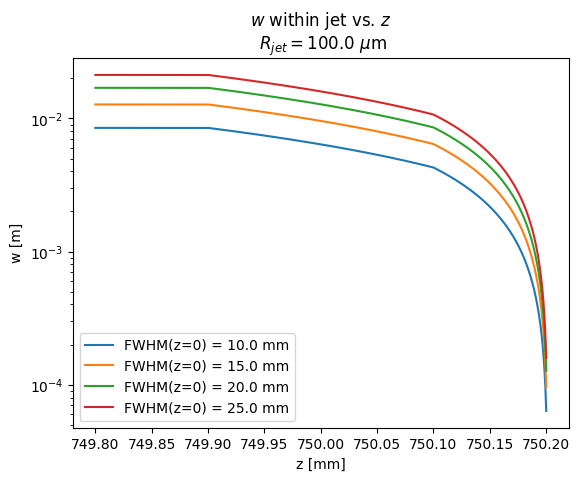

In [ ]:
'''
Propagate:
100 um jet ==> R_jet = 50 um
Input beam diameter = D = 25 mm
Input beam color = 266 nm
'''
l0 = 266e-9
fwhm0_arr = np.array([10e-3, 15e-3, 20e-3, 25e-3])
w0_arr = f2w(fwhm0_arr)
r_jet = 100e-6
eps = r_jet/1e4 # r_jet/1000 # stay inside jet

sys = sys_img_jet(r_jet=r_jet)

ZSCALE=1e3
ZSCALE_STR='mm'

for w0 in w0_arr:
  q0 = q(R0, l0, N0, w0)

  z1 = Z_JET - 2*r_jet - eps
  z2 = Z_JET + 2*r_jet + eps
  z = np.linspace(z1, z2, 1000)
  q_init = sys.propagate(q0, [Z_LENS, z1])[-1]
  q_z = sys.propagate(q0, z)
  w_z = q2w(q_z, sys.n(z), l0)

  print(get_min_w)

  plt.semilogy(z*ZSCALE, w_z, label='FWHM(z=0) = ' + str(w2f(w0)*1e3) + ' mm')

plt.title('$w$ within jet vs. $z$ \n $R_{jet}=$'+str(r_jet*1e6)+' $\mu$m')
plt.xlabel(f'z [{ZSCALE_STR}]')
plt.ylabel('w [m]')
plt.legend()
plt.show()



In [ ]:
# Propagate:
# FWHM(z=0) input beam diameter = 25 mm

## Plot intensity throughout volume


In [ ]:
# Define the 2D Gaussian function
def gaussian_2d(x, y, mu_x, mu_y, sigma_x, sigma_y):
    return (1 / (2 * np.pi * sigma_x * sigma_y)) * np.exp(- ((x - mu_x)**2 / (2 * sigma_x**2) + (y - mu_y)**2 / (2 * sigma_y**2)))

# make a 3D tensor representing beam volume
z = np.linspace(Z_LENS, Z_CAM, 1000)
q0 = q(R0, L0, N0, W0)
q_z =

SyntaxError: invalid syntax (<ipython-input-41-18e1177184d9>, line 8)

# Miscellaneous
Leftover from other versions of notebook; may be broken by recent changes

In [ ]:
# Compare sheet to jets and non-jet


plt.figure()
plt.xlabel('$D=$FWHM at $z=0$ [mm]')
plt.ylabel('$w_{\min} \propto$Minimum FWHM inside jet [$\mu$m]')

# Sweep w_0 for each R_jet
for R_jet in R_jet_arr:
  w_min_arr = []
  z_min_arr = []
  for w_0 in w_0_arr:
    w_min, z_min, _, _ = get_min_w_in_jet(R_jet, w_0)
    w_min_arr.append(w_min)
    z_min_arr.append(z_min)
  fwhm_min_arr = w2f(np.array(w_min_arr))
  plt.plot(fwhm_0_arr * 1e3, fwhm_min_arr * 1e6, label='$R_{jet} = $' + str(R_jet*1e6) + ' $\mu$m')

# Plot the no jet case
w_min_arr = []
z_min_arr = []
for w_0 in w_0_arr:
  w_min, z_min, _, _ = get_min_w_in_jet(R_jet_arr[-1], w_0, no_jet=True)
  w_min_arr.append(w_min)
  z_min_arr.append(z_min)
fwhm_min_arr = w2f(np.array(w_min_arr))
plt.plot(fwhm_0_arr * 1e3, fwhm_min_arr * 1e6, 'k--', label='No jet')

# Plot the sheets case
# Sweep w_0 for each R_jet
for R_jet in R_jet_arr:
  w_min_arr = []
  z_min_arr = []
  for w_0 in w_0_arr:
    w_min, z_min, _, _ = get_min_w_in_sheet(R_jet, w_0)
    w_min_arr.append(w_min)
    z_min_arr.append(z_min)
  fwhm_min_arr = w2f(np.array(w_min_arr))
  plt.plot(fwhm_0_arr * 1e3, fwhm_min_arr * 1e6, label='$t_{sheet} = $' + str(2*R_jet*1e6) + ' $\mu$m')

plt.legend()

In [ ]:
# Sweep w_0 for each R_jet

plt.figure()
plt.xlabel('FWHM at $z=0$ [mm]')
plt.ylabel('Minimum FWHM inside jet [$\mu$m]')

for R_jet in R_jet_arr:
  w_min_arr = []
  z_min_arr = []
  for w_0 in w_0_arr:
    w_min, z_min, _, _ = get_min_w_in_jet(R_jet, w_0)
    w_min_arr.append(w_min)
    z_min_arr.append(z_min)
  fwhm_min_arr = w2f(np.array(w_min_arr))
  plt.plot(fwhm_0_arr * 1e3, fwhm_min_arr * 1e6, label='$R_{jet} = $' + str(R_jet*1e6) + ' $\mu$m')

fwhm_min_arr_jet = fwhm_min_arr # R_jet = 50 um

# w_min, z_min, _, _ = get_min_w_in_jet(R_jet, w_0)

# Plot the no jet case
w_min_arr = []
z_min_arr = []
for w_0 in w_0_arr:
  w_min, z_min, _, _ = get_min_w_in_jet(R_jet_arr[-1], w_0, no_jet=True)
  w_min_arr.append(w_min)
  z_min_arr.append(z_min)
fwhm_min_arr_no_jet = w2f(np.array(w_min_arr))
plt.plot(fwhm_0_arr * 1e3, fwhm_min_arr_no_jet * 1e6, 'k--', label='No jet')

plt.legend()

In [ ]:
# Get beam waist at FWHM(z = 0) = 5 mm
input_FWHM = 5e-3
w_jet_5mm = fwhm_min_arr_jet[np.where(fwhm_0_arr == input_FWHM)]
w_no_jet_5mm = fwhm_min_arr_no_jet[np.where(fwhm_0_arr == input_FWHM)]

NOTE: change in code below

$$I(r,z) = { |E(r,z)|^2  \over  2 \eta } = I_0 \left( \frac{w_0}{w(z)} \right)^2 \exp \left( \frac{-2r^2}{w(z)^2}\right),$$

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Define the 2D Gaussian function
def gaussian_2d(x, y, mu_x, mu_y, sigma_x, sigma_y):
    return (1 / (2 * np.pi * sigma_x * sigma_y)) * np.exp(- ((x - mu_x)**2 / (2 * sigma_x**2) + (y - mu_y)**2 / (2 * sigma_y**2)))

# Parameters for the Gaussian function
mu_x, mu_y = 0, 0  # Mean
sigma_x, sigma_y = W0, W0  # Standard deviation

# Create a grid of x and y values
x = np.linspace(-5e-3, 5e-3, 100)
y = np.linspace(-5e-3, 5e-3, 100)
X, Y = np.meshgrid(x, y)
Z = gaussian_2d(X, Y, mu_x, mu_y, sigma_x, sigma_y)
I0 = np.max(Z)
Z /= I0

# Plot the Gaussian using the Inferno colormap
plt.figure(figsize=(8, 6))
plt.imshow(Z, extent=(x.min()*1e3, x.max()*1e3, y.min()*1e3, y.max()*1e3), origin='lower', cmap='inferno')
plt.colorbar(label='Intensity [$I_0$]')
plt.title('Input beam')
plt.xlabel('x [mm]')
plt.ylabel('y [mm]')
plt.show()


In [ ]:
# NO JET
from matplotlib.patches import Ellipse

# Define the 2D Gaussian function
def gaussian_2d(x, y, mu_x, mu_y, sigma_x, sigma_y):
    return (1 / (2 * np.pi * sigma_x * sigma_y)) * np.exp(- ((x - mu_x)**2 / (2 * sigma_x**2) + (y - mu_y)**2 / (2 * sigma_y**2)))

# Parameters for the Gaussian function
mu_x, mu_y = 0, 0  # Mean
sigma_x, sigma_y = w_no_jet_5mm/2, w_no_jet_5mm/2  # Standard deviation

# Create a grid of x and y values
x = np.linspace(-100e-6, 100e-6, 100)
y = np.linspace(-100e-6, 100e-6, 100)
X, Y = np.meshgrid(x, y)
Z = gaussian_2d(X, Y, mu_x, mu_y, sigma_x, sigma_y) * (w_0**2 / (w_no_jet_5mm**2))
I0 = Z.max()
Z /= I0

# Plot the Gaussian using the Inferno colormap
# Plot the Gaussian using the Inferno colormap
SCALE = 1e6

plt.figure(figsize=(8, 6))
plt.imshow(Z, extent=(x.min()*SCALE, x.max()*SCALE, y.min()*SCALE, y.max()*SCALE), origin='lower', cmap='inferno')

# Plot the white dashed ellipse
ellipse = Ellipse((mu_x, mu_y), 2 * sigma_x * SCALE, 2 * sigma_y * SCALE, edgecolor='white', facecolor='none', linestyle='--')
ax = plt.gca()
ax.add_patch(ellipse)

plt.colorbar(label='Intensity [$I_0$]')
plt.title(f'No jet; $z={z_jet}$ m')
plt.xlabel('x [μm]')
plt.ylabel('y [μm]')
plt.show()



In [ ]:
# WITH JET

# Define the 2D Gaussian function
def gaussian_2d(x, y, mu_x, mu_y, sigma_x, sigma_y):
    return (1 / (2 * np.pi * sigma_x * sigma_y)) * np.exp(- ((x - mu_x)**2 / (2 * sigma_x**2) + (y - mu_y)**2 / (2 * sigma_y**2)))

# Parameters for the Gaussian function
mu_x, mu_y = 0, 0  # Mean
sigma_x, sigma_y = w_no_jet_5mm/2, w_jet_5mm/2  # Standard deviation

# Create a grid of x and y values
x = np.linspace(-100e-6, 100e-6, 100)
y = np.linspace(-100e-6, 100e-6, 100)
X, Y = np.meshgrid(x, y)
Z = gaussian_2d(X, Y, mu_x, mu_y, sigma_x, sigma_y) * (w_0**2 / (w_no_jet_5mm**2))
# I0 = Z.max()
Z /= I0



# Plot the Gaussian using the Inferno colormap
SCALE = 1e6

plt.figure(figsize=(8, 6))
plt.imshow(Z, extent=(x.min()*SCALE, x.max()*SCALE, y.min()*SCALE, y.max()*SCALE), origin='lower', cmap='inferno')

# Plot the white dashed ellipse
ellipse = Ellipse((mu_x, mu_y), 2 * sigma_x * SCALE, 2 * sigma_y * SCALE, edgecolor='white', facecolor='none', linestyle='--')
ax = plt.gca()
ax.add_patch(ellipse)

plt.colorbar(label='Intensity [$I_0$]')
plt.title('Jet, $R_{jet}=50$ μm')
plt.xlabel('x [μm]')
plt.ylabel('y [μm]')
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize

# Generate the parameter values
t = np.linspace(0, 10 * np.pi, 1000)

# Parametric equations
x = np.cos(t)
y = np.sin(t)
z = t

# Normalize the parameter values for color mapping
norm = Normalize(vmin=t.min(), vmax=t.max())
cmap = plt.cm.viridis

# Create a 3D plot
fig = plt.figure(figsize=(12, 6))
ax1 = fig.add_subplot(121, projection='3d')

# Plot the 3D curve with color gradient
for i in range(len(t) - 1):
    ax1.plot(x[i:i+2], y[i:i+2], z[i:i+2], color=cmap(norm(t[i])))

# Add labels and title to the 3D plot
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_zlabel('Z')
ax1.set_title('3D Parametric Curve with Color Gradient')

# Create a ScalarMappable and add the colorbar to the 3D plot
sm = ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # Only needed for the colorbar
cbar = plt.colorbar(sm, ax=ax1)
cbar.set_label('Parameter t')

# Create a 2D plot for the xy-plane projection
ax2 = fig.add_subplot(122)

# Plot the xy projection with color gradient
for i in range(len(t) - 1):
    ax2.plot(x[i:i+2], y[i:i+2], color=cmap(norm(t[i])))

# Add labels and title to the 2D plot
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.set_title('XY-plane Projection')

# Show plot
plt.show()


μ

In [ ]:

for w_0 in w_0_arr:
  for R_jet in R_jet_arr:
    w_x_min, z_min, _, _ = get_min_w_in_jet(R_jet, w_0)

    # Calculate area of ellipse at z_min
    A = np.pi * w_min * w_jet_5mm

    fwhm = w2f(w_min)

In [ ]:
for r_jet in r_jet_arr:
  print(f'R_jet = {r_jet*1e6} um')
  w_min_arr = []
  z_min_arr = []
  A_arr = []
  # Report w0 and associated values every 1 mm
  threshold = 1e-3
  for w_0 in w0_arr:
    w_x_min, z_min, _, _ = get_min_w_in_jet(R_jet, w_0)
    w_min_arr.append(w_x_min)
    z_min_arr.append(z_min)

    # Calculate w_y at z_min

    # Optical system for Y dimension calculations
    sys_y = OpticalSystem()
    sys_y.add(ThinLens(f), z=0)
    # Add a sheet of thickness 2*R_jet
    sys_y.add(Sheet(t=2*R_jet, n=n_jet), z=z_jet)
    # Initialize input beam
    q0 = q(R_0, l_0, n_0, w_0)

    # Propagate to z_min
    q_y = sys_y.propagate(q0, [z_lens, z_min])[-1]
    w_y = np.real(q2w(q_y, n_jet, l_0))
    # Calculate area of ellipse at z_min
    A = np.pi * w_x_min * w_y
    A_arr.append(A)

    # Report every 1 mm
    if w_0 > threshold:
      threshold += 1e-3
      print(f'\t w_0 = {w_0 * 1e3} mm:')
      print(f'\t\t z_min = z_jet + {(z_min - z_jet)*1e6} um')
      print(f'\t\t w_x_min = {w_x_min*1e6} um')
      print(f'\t\t w_y_min = {w_y * 1e6} um')
      print()

  fwhm_min_arr = w2f(np.array(w_min_arr))
  plt.plot(np.array(A_arr) * 1e12, fwhm_min_arr * 1e6, label='$R_{jet} = $' + str(R_jet*1e6) + ' $\mu$m')

  # t = w_0_arr/

  # # Normalize the parameter values for color mapping
  # norm = Normalize(vmin=t.min(), vmax=t.max())
  # cmap = plt.cm.viridis

  # # Create a 3D plot
  # fig = plt.figure(figsize=(12, 6))
  # ax1 = fig.add_subplot(121, projection='3d')

  # # Plot the 3D curve with color gradient
  # for i in range(len(t) - 1):
  #     ax1.plot(x[i:i+2], y[i:i+2], z[i:i+2], color=cmap(norm(t[i])))

  # # Add labels and title to the 3D plot
  # ax1.set_xlabel('X')
  # ax1.set_ylabel('Y')
  # ax1.set_zlabel('Z')
  # ax1.set_title('3D Parametric Curve with Color Gradient')

  # # Create a ScalarMappable and add the colorbar to the 3D plot
  # sm = ScalarMappable(cmap=cmap, norm=norm)
  # sm.set_array([])  # Only needed for the colorbar
  # cbar = plt.colorbar(sm, ax=ax1)
  # cbar.set_label('Parameter t')

  # # Create a 2D plot for the xy-plane projection
  # ax2 = fig.add_subplot(122)

  # # Plot the xy projection with color gradient
  # for i in range(len(t) - 1):
  #     ax2.plot(x[i:i+2], y[i:i+2], color=cmap(norm(t[i])))

  # Add labels and title to the 2D plot
  # ax2.set_xlabel('X')
  # ax2.set_ylabel('Y')
  # ax2.set_title('XY-plane Projection')

  # Show plot
  # plt.show()

plt.legend()
plt.title('Minimum spot area $A_{min}$ vs. minimum beam waist $w_{x,min}$')
plt.xlabel('Minimum spot area within jet [μm$^2$]')
plt.ylabel('Minimum FWHM in jet [μm]')


In [ ]:
# Sweep w_0 for each R_jet

plt.figure()
plt.xlabel('$D=$FWHM at $z=0$ [mm]')
plt.ylabel('$w_{\min} \propto$Minimum FWHM inside jet [$\mu$m]')

for r_jet in r_jet_arr:
  w_min_arr = []
  z_min_arr = []
  for w_0 in w0_arr:
    w_min, z_min, _, _ = get_min_w(r_jet, w_0)
    w_min_arr.append(w_min)
    z_min_arr.append(z_min)
  fwhm_min_arr = w2f(np.array(w_min_arr))
  plt.plot(fwhm_0_arr * 1e3, fwhm_min_arr * 1e6, label='$R_{jet} = $' + str(R_jet*1e6) + ' $\mu$m')

# Plot the no jet case
w_min_arr = []
z_min_arr = []
for w_0 in w_0_arr:   # TODO: vectorize this!
  w_min, z_min, _, _ = get_min_w_in_jet(R_jet_arr[-1], w_0, no_jet=True)
  w_min_arr.append(w_min)
  z_min_arr.append(z_min)
fwhm_min_arr = w2f(np.array(w_min_arr))
plt.plot(fwhm_0_arr * 1e3, fwhm_min_arr * 1e6, 'k--', label='No jet')

plt.legend()